In [251]:
import networkx as nx
import scipy as sp
import numpy as np
import random
import copy
import math
from scipy import sparse
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from networkx.algorithms.community.label_propagation import label_propagation_communities
import collections

%matplotlib inline

In [111]:
political=nx.read_gml("polblogs.gml",label='id')

#make the graph directed with no parallels
political = nx.DiGraph(political)

#returns a set of nodes of the biggest connected component
largest = max(nx.connected_components(political.to_undirected()), key=len)

# creates the graph of the biggest connected component including direction
CC_max = political.subgraph(largest)


In [249]:
a = CC_max.copy()

convergence_factor = 0.000001

#get the b% of values
percentage=10

# re-index node id's to simply proccess, original id's are stored in a label.
CC_max = nx.convert_node_labels_to_integers(CC_max, first_label=0, ordering='default', label_attribute='original_graph_id')

#Returns a list with the value of the nodes
original_values = dict(CC_max.nodes(data='value'))

numbers_of_items_kept_from_percentage = round(len(a)*(percentage*0.01))

precision_list = []

standard_deviation_list = []

for i in range(9):
    
    print("Now computing nodes for:",percentage,"%")
    print("========================")
    
    sum_of_precision = 0
    precision_results = 0
    list_of_precision_for_every_experiment = []
    
    for i in range(10):
        
        true_positive = 0
        false_positive = 0
        precision = 0
        
        # shuffle the dictionary of values to get the random nodes

        shuffled = dict(original_values.items())
        shuffled_list = list(shuffled.items())
        np.random.shuffle(shuffled_list)
        shuffled = dict(shuffled_list)


        #keep the first percentage b% of the nodes
        nodes_kept = list(shuffled.items())[:numbers_of_items_kept_from_percentage]

        nodes_kept_dictionary = dict(nodes_kept)

        nodes_to_discover = list(shuffled.items())[numbers_of_items_kept_from_percentage:]

        nodes_to_be_discovered_dictionary = dict(nodes_to_discover)

        nodes_with_known_value = list(dict(nodes_kept).keys())


        #initialize not known node values

        for key in dict(nodes_kept).keys():
            shuffled[key] = 0.5


        #the previous values holds a n x 2 matrix with the original node values
        #the first column represent the id the second one the node value
        previous_values = np.array(list(original_values.items()),dtype='f')

        #drop id's so we have a clean n x 1 matrix with the original values
        previous_values = np.delete(previous_values, 0, 1)

        #the same applies for the new values variable
        new_values = np.array(list(original_values.items()),dtype='f')

        #drop id's
        new_values = np.delete(new_values, 0, 1)

        #the previous_values and new_values will be updated inside the while loop

        # adjacency matrix of the graph
        A = nx.adjacency_matrix(CC_max)

        # a n x 1 matrix that holds how many neighbors each node has
        sum_of_neighbors = np.sum(A,axis=1)

        # numbers of nodes
        size_of_vector = np.size(sum_of_neighbors,0)


        while True:

            new_values = A * new_values

            #new_values after the multiplication is a n x 1 matrix
            #we need to change the known nodes to their original value

            for key in nodes_kept_dictionary.keys():
                
                new_values[key] = nodes_kept_dictionary[key]



            #now we need to divide all nodes that we are trying to predict with how many neighbors they have

            for key in nodes_to_be_discovered_dictionary.keys():
            
                #check for NaNs
                division = new_values[key] / sum_of_neighbors[key]
                
                if(division != division): 
                    new_values[key] = 0
                else:
                    new_values[key] = division
                


            # 1 x n Matrix
            norm_previous = np.sum(previous_values, axis=0)

            # 1 x n Matrix
            norm_new = np.sum(new_values, axis=0)


            norm_difference = abs(norm_new - norm_previous)


            if norm_difference < convergence_factor:
                break

            previous_values = new_values 
        
        
        #update the new values
        for i,obj in enumerate(new_values):
            if new_values[i] >0.5:
                new_values[i] = 1
            else:
                new_values[i] = 0
        
        #Now compare original values with the values after the propagation
        
        for index in nodes_to_be_discovered_dictionary.keys():
            if(original_values[index] == new_values[index]):
                true_positive += 1
        
        
        false_positive = size_of_vector - numbers_of_items_kept_from_percentage - true_positive

        precision = true_positive / (true_positive + false_positive)

        sum_of_precision += precision
        
        list_of_precision_for_every_experiment.append(precision)
             
    precision_results = sum_of_precision / 10
    precision_list.append(precision_results)
    
    difference_sum = 0
    
    standard_deviation_list.append(np.std(list_of_precision_for_every_experiment))

    
    #update percentage
    percentage += 10  
    numbers_of_items_kept_from_percentage = round(len(a)*(percentage*0.01))
    


Now computing nodes for: 10 %
Now computing nodes for: 20 %
Now computing nodes for: 30 %
Now computing nodes for: 40 %
Now computing nodes for: 50 %
Now computing nodes for: 60 %
Now computing nodes for: 70 %
Now computing nodes for: 80 %
Now computing nodes for: 90 %


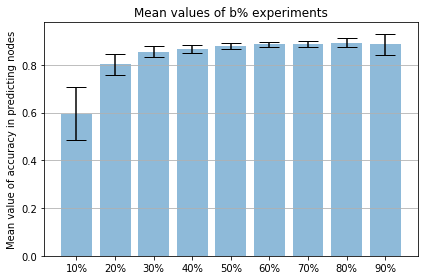

In [253]:
percentages = ['10%', '20%', '30%','40%', '50%', '60%','70%', '80%', '90%']
x_pos = np.arange(len(percentages))
CTEs = precision_list
error = standard_deviation_list

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, precision_list, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean value of accuracy in predicting nodes')
ax.set_xticks(x_pos)
ax.set_xticklabels(percentages)
ax.set_title('Mean values of b% experiments')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()